<a href="https://colab.research.google.com/github/b00094096/COE486/blob/main/zero_shot_object_detection_with_yolo_world_copy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Zero-Shot Object Detection with YOLO-World
---

YOLO-World was designed to solve a limitation of existing zero-shot object detection models: speed. Whereas other state-of-the-art models use Transformers, a powerful but typically slower architecture, YOLO-World uses the faster CNN-based YOLO architecture.

According to the paper YOLO-World reached between 35.4 AP with 52.0 FPS for the large version and 26.2 AP with 74.1 FPS for the small version. While the V100 is a powerful GPU, achieving such high FPS on any device is impressive.

![visualization results of referring object detection](https://storage.googleapis.com/com-roboflow-marketing/supervision/cookbooks/yolo-world-visualization-results-of-referring-object-detection.png)

## Before you start

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `GPU`, and then click `Save`.

In [1]:
!nvidia-smi

Fri Dec  5 15:37:33 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   49C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

**NOTE:** To make it easier for us to manage datasets, images and models we create a `HOME` constant.

In [2]:
import os
HOME = os.getcwd()
print(HOME)

/content


## Install required packages

In this guide, we utilize two Python packages: `inference`, for executing zero-shot object detection using YOLO-World, and `supervision`, for post-processing and visualizing the detected objects.

In [3]:
!pip install -q ultralytics supervision opencv-python

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 30.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.4/212.4 kB 16.1 MB/s eta 0:00:00


In [4]:
!pip install -q ultralytics
!pip install -q supervision==0.19.0rc3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.8/90.8 kB 4.3 MB/s eta 0:00:00


## Imports

In [5]:
import cv2
import supervision as sv
import numpy as np

from tqdm import tqdm
from ultralytics import YOLOWorld

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


## Download example data

In [6]:
!wget -P {HOME} -q https://media.roboflow.com/notebooks/examples/dog.jpeg
!wget -P {HOME} -q https://media.roboflow.com/supervision/cookbooks/yellow-filling.mp4

In [7]:
SOURCE_IMAGE_PATH = f"{HOME}/dog.jpeg"
SOURCE_VIDEO_PATH = f"{HOME}/yellow-filling.mp4"

**NOTE:** If you want to run the cookbook using your own file as input, simply upload video to Google Colab and replace `SOURCE_IMAGE_PATH` and `SOURCE_VIDEO_PATH` with the path to your file.

## Run Object Detection

The Inference package provides the YOLO-World model in three versions: `S`, `M`, and `L`. You can load them by defining model_id as `yolo_world/s`, `yolo_world/m`, and `yolo_world/l`, respectively. The `ROBOFLOW_API_KEY` is not required to utilize this model.







In [8]:
model = YOLOWorld("yolov8s-world.pt")

YOLO-World is a zero-shot model, enabling object detection without any training. You only need to define a prompt as a list of classes (things) you are searching for.

In [9]:
classes = ["person", "backpack", "dog", "eye", "nose", "ear", "tongue"]
model.set_classes(classes)

requirements: Ultralytics requirement ['git+https://github.com/ultralytics/CLIP.git'] not found, attempting AutoUpdate...
Using Python 3.12.12 environment at: /usr
Resolved 34 packages in 709ms
Prepared 2 packages in 2.75s
Installed 2 packages in 2ms
 + clip==1.0 (from git+https://github.com/ultralytics/CLIP.git@4f352ca0a7450598833a770314f73e1f74e05f30)
 + ftfy==6.3.1

requirements: AutoUpdate success ✅ 3.9s
WARNING ⚠️ requirements: Restart runtime or rerun command for updates to take effect



100%|███████████████████████████████████████| 338M/338M [00:11<00:00, 29.8MiB/s]


We perform detection on our sample image. Then, we convert the result into a [`sv.Detections`](https://supervision.roboflow.com/latest/detection/core/) object, which will be useful in the later parts of the cookbook.

In [10]:
image = cv2.imread(SOURCE_IMAGE_PATH)
result = model.predict(image, verbose=False)[0]
detections = sv.Detections.from_ultralytics(result)


The results we've obtained can be easily visualized with [`sv.BoundingBoxAnnotator`](https://supervision.roboflow.com/latest/annotators/#supervision.annotators.core.BoundingBoxAnnotator) and [`sv.LabelAnnotator`](https://supervision.roboflow.com/latest/annotators/#supervision.annotators.core.LabelAnnotator). We can adjust parameters such as line thickness, text scale, line and text color allowing for a highly tailored visualization experience.

In [11]:
BOUNDING_BOX_ANNOTATOR = sv.BoundingBoxAnnotator(thickness=2)
LABEL_ANNOTATOR = sv.LabelAnnotator(text_thickness=2, text_scale=1, text_color=sv.Color.BLACK)

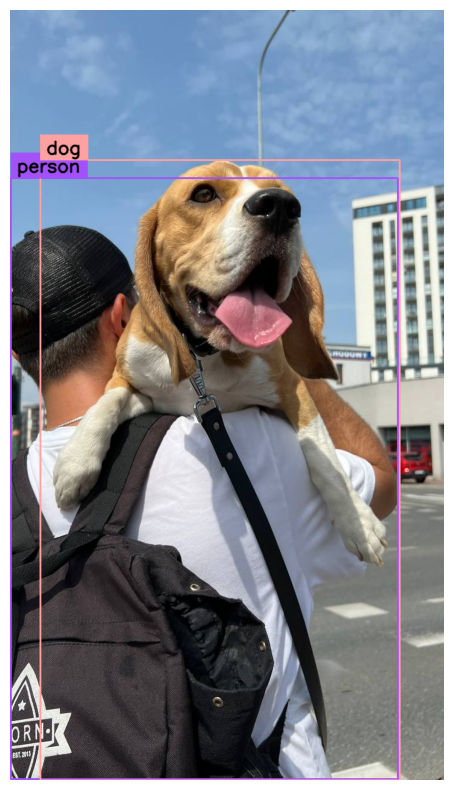

In [12]:
annotated_image = image.copy()
annotated_image = BOUNDING_BOX_ANNOTATOR.annotate(annotated_image, detections)
annotated_image = LABEL_ANNOTATOR.annotate(annotated_image, detections)
sv.plot_image(annotated_image, (10, 10))

## Adjusting Confidence Level

Note that many classes from our prompt were not detected. This is because the default confidence threshold in Inference is set to `0.5`. Let's try significantly lowering this value. We've observed that the confidence returned by YOLO-World is significantly lower when querying for classes outside the [COCO](https://universe.roboflow.com/microsoft/coco) dataset.

In [13]:
result = model.predict(image, conf=0.003, verbose=False)[0]
detections = sv.Detections.from_ultralytics(result)


By default, `sv.LabelAnnotator` displays only the names of objects. To also view the confidence levels associated with each detection, we must define custom `labels` and pass them to `sv.LabelAnnotator`.

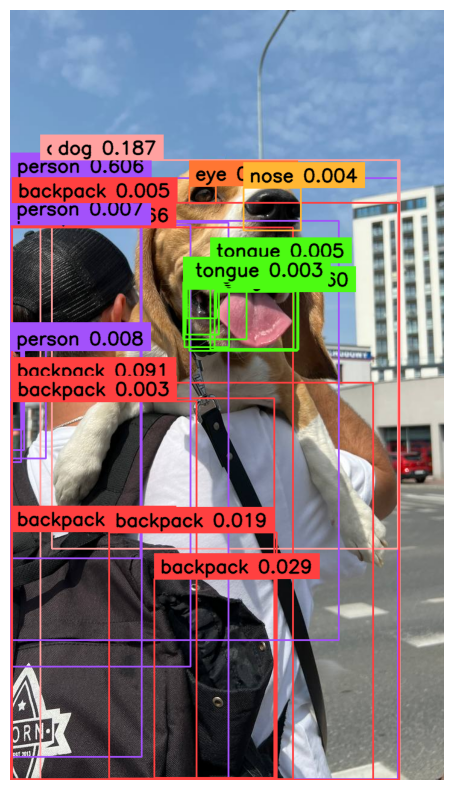

In [14]:
labels = [
    f"{classes[class_id]} {confidence:0.3f}"
    for class_id, confidence
    in zip(detections.class_id, detections.confidence)
]

annotated_image = image.copy()
annotated_image = BOUNDING_BOX_ANNOTATOR.annotate(annotated_image, detections)
annotated_image = LABEL_ANNOTATOR.annotate(annotated_image, detections, labels=labels)
sv.plot_image(annotated_image, (10, 10))

## Using Non-Max Suppression (NMS) to Eliminate Double Detections

To eliminate duplicates, we will use [Non-Max Suppression (NMS)](https://blog.roboflow.com/how-to-code-non-maximum-suppression-nms-in-plain-numpy). NMS evaluates the extent to which detections overlap using the Intersection over Union metric and, upon exceeding a defined threshold, treats them as duplicates. Duplicates are then discarded, starting with those of the lowest confidence. The value should be within the range `[0, 1]`. The smaller the value, the more restrictive the NMS.







In [15]:
image = cv2.imread(SOURCE_IMAGE_PATH)
result = model.predict(image, conf=0.003, verbose=False)[0]
detections = sv.Detections.from_ultralytics(result).with_nms(threshold=0.5)

keep_idx = []
for cid in np.unique(detections.class_id):
    idx = np.where(detections.class_id == cid)[0]
    best = idx[np.argmax(detections.confidence[idx])]
    keep_idx.append(best)

detections = detections[keep_idx]


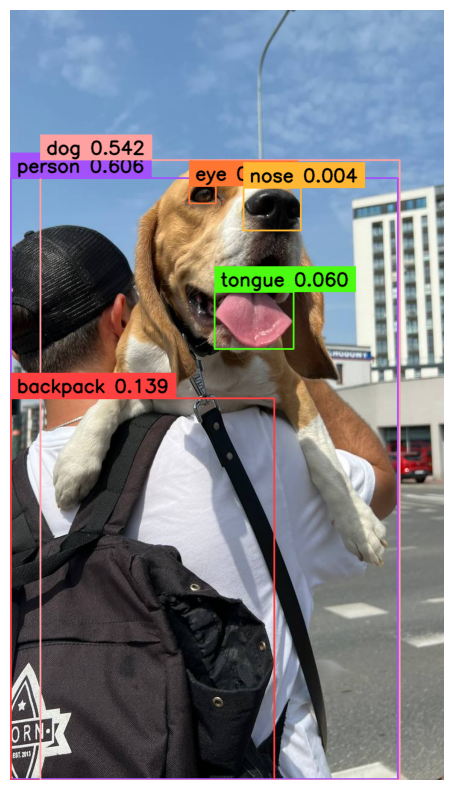

In [16]:
labels = [
    f"{classes[class_id]} {confidence:0.3f}"
    for class_id, confidence
    in zip(detections.class_id, detections.confidence)
]

annotated_image = image.copy()
annotated_image = BOUNDING_BOX_ANNOTATOR.annotate(annotated_image, detections)
annotated_image = LABEL_ANNOTATOR.annotate(annotated_image, detections, labels=labels)
sv.plot_image(annotated_image, (10, 10))

## Video Processing

The [`get_video_frames_generator`](https://supervision.roboflow.com/latest/utils/video/#supervision.utils.video.get_video_frames_generator) enables us to easily iterate over video frames. Let's create a video generator for our sample input file and display its first frame on the screen.

Let's update our list of classes. This time we are looking for `yellow filling`. The rest of the code performing detection, filtering and visualization remains unchanged.

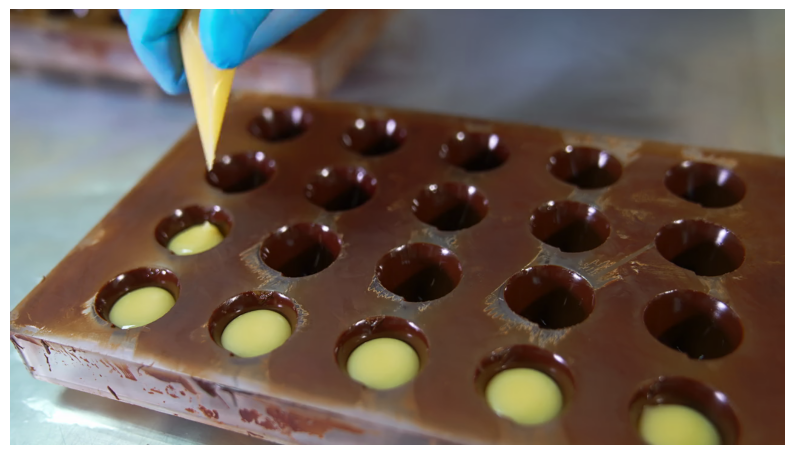

In [17]:
generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)
frame = next(generator)

sv.plot_image(frame, (10, 10))

In [19]:
model.to("cpu")
classes = ["yellow filling"]
model.set_classes(classes)


In [20]:
results = model.predict(frame, conf=0.002, verbose=False)[0]
detections = sv.Detections.from_ultralytics(results).with_nms(threshold=0.1)


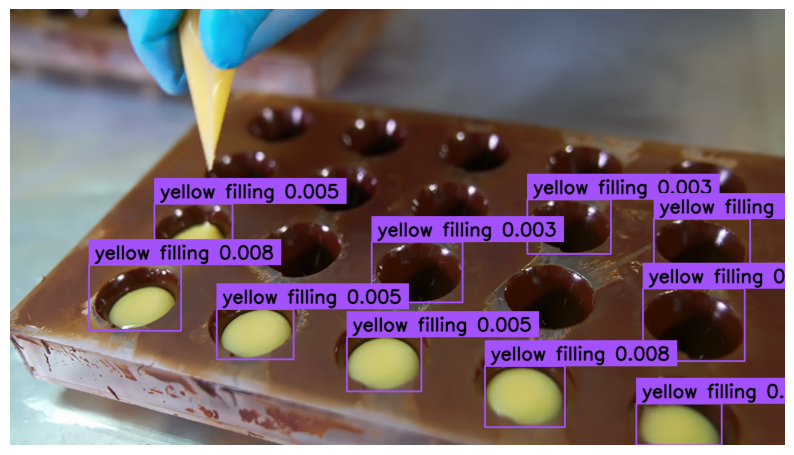

In [21]:
labels = [
    f"{classes[class_id]} {confidence:0.3f}"
    for class_id, confidence in zip(detections.class_id, detections.confidence)
]

annotated_image = frame.copy()
annotated_image = BOUNDING_BOX_ANNOTATOR.annotate(annotated_image, detections)
annotated_image = LABEL_ANNOTATOR.annotate(annotated_image, detections, labels=labels)
sv.plot_image(annotated_image, (10, 10))


## Filtering Detectuions by Area

Our prompt allowed us to locate all filled holes, but we also accidentally marked some wrong fillings in the bar. To address this issue, we'll filter detections based on their relative area in relation to the entire video frame. If a detection occupies less than 0.18 ratio of dark empty holes, it will be discarded.

We can use [`VideoInfo.from_video_path`](https://supervision.roboflow.com/develop/utils/video/#supervision.utils.video.VideoInfo) to learn basic information about our video, such as duration, resolution, or FPS.

In [22]:
video_info = sv.VideoInfo.from_video_path(SOURCE_VIDEO_PATH)
video_info

VideoInfo(width=1280, height=720, fps=25, total_frames=442)

Knowing the frame's resolution allows us to easily calculate its total area, expressed in pixels.

In [23]:
width, height = video_info.resolution_wh
frame_area = width * height
frame_area

921600

On the other hand, by using [`sv.Detections.area`](https://supervision.roboflow.com/develop/detection/core/#supervision.detection.core.Detections.area) property, we can learn the area of each individual bounding box.

In [24]:
results = model.predict(
    frame,
    conf=0.003,
    iou=0.45,
    verbose=False
)[0]

detections = sv.Detections.from_ultralytics(results).with_nms(threshold=0.1)

h, w, _ = frame.shape
xyxy = detections.xyxy.astype(int)

hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
lower_yellow = np.array([15, 80, 80], dtype=np.uint8)
upper_yellow = np.array([40, 255, 255], dtype=np.uint8)

keep_idx = []

for i, (x1, y1, x2, y2) in enumerate(xyxy):
    x1 = max(0, x1); y1 = max(0, y1)
    x2 = min(w, x2); y2 = min(h, y2)
    if x2 <= x1 or y2 <= y1:
        continue

    box_h = y2 - y1
    y_center = (y1 + y2) / 2.0


    if box_h > 0.6 * h:
        continue
    if y_center < 0.45 * h:
        continue

    crop = hsv[y1:y2, x1:x2]
    mask = cv2.inRange(crop, lower_yellow, upper_yellow)
    yellow_ratio = mask.mean() / 255.0   # 0..1

    if yellow_ratio < 0.18:
        continue

    keep_idx.append(i)

detections = detections[keep_idx]

Now, we can combine these two pieces of information to construct a filtering condition for detections with an area greater than 10% of the entire frame.

In [25]:
(detections.area / frame_area) < 0.10

array([ True,  True,  True,  True,  True,  True])

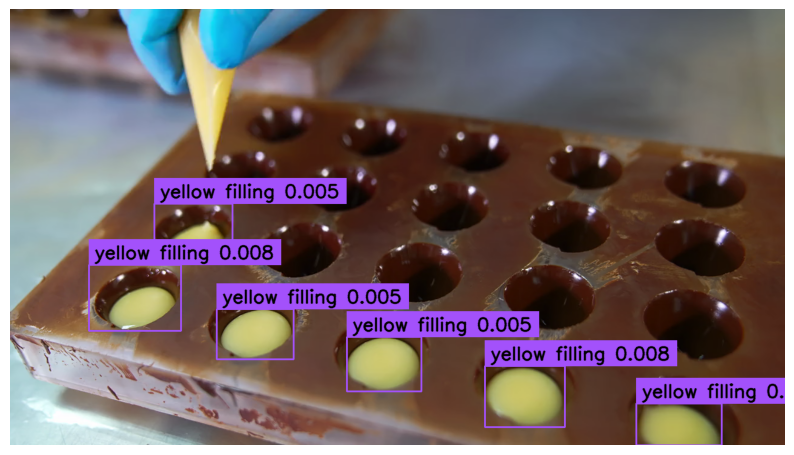

In [26]:
labels = [
    f"{classes[class_id]} {confidence:0.3f}"
    for class_id, confidence in zip(detections.class_id, detections.confidence)
]

annotated_image = frame.copy()
annotated_image = BOUNDING_BOX_ANNOTATOR.annotate(annotated_image, detections)
annotated_image = LABEL_ANNOTATOR.annotate(annotated_image, detections, labels=labels)
sv.plot_image(annotated_image, (10, 10))


## Final Result

Finally, we are ready to process our entire video. Now in truth we can appreciate the speed of YOLO-World.

In [27]:
TARGET_VIDEO_PATH = f"{HOME}/yellow-filling-output.mp4"

In [30]:
TARGET_VIDEO_PATH = f"{HOME}/yellow-filling-output.mp4"

video_info = sv.VideoInfo.from_video_path(SOURCE_VIDEO_PATH)
width, height = video_info.resolution_wh
frame_area = width * height

frame_generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)

with sv.VideoSink(target_path=TARGET_VIDEO_PATH, video_info=video_info) as sink:
    for frame in tqdm(frame_generator, total=video_info.total_frames):

        results = model.predict(
            frame,
            conf=0.002,
            verbose=False
        )[0]

        detections = sv.Detections.from_ultralytics(results).with_nms(threshold=0.1)

        rel_area = detections.area / frame_area
        mask = (rel_area > 0.0005) & (rel_area < 0.02)
        detections = detections[mask]

        annotated_frame = frame.copy()
        annotated_frame = BOUNDING_BOX_ANNOTATOR.annotate(annotated_frame, detections)
        annotated_frame = LABEL_ANNOTATOR.annotate(
            annotated_frame,
            detections,
            labels=[
                f"{classes[cid]} {conf:0.3f}"
                for cid, conf in zip(detections.class_id, detections.confidence)
            ],
        )
        sink.write_frame(annotated_frame)


100%|██████████| 442/442 [02:18<00:00,  3.19it/s]
